#### HDBSCAN

In this notebook we used a variation of the DBSCAN algorithm called HDBSCAN. 
It is already implemented in the library "HDBSCAN"


-  [Documentation](https://hdbscan.readthedocs.io/en/latest/outlier_detection.html)

-  [Github](https://github.com/scikit-learn-contrib/hdbscan)


In [2]:
import pandas as pd
import numpy as np
import os 
import random
from Funciones import *
from scipy.spatial.distance import cdist
medida = 'euclidean'

random.seed(42)

import pygad 

import hdbscan

### First, we load the data

In [3]:
# Paths and Embeddings for the training set
set = 'Mobio'
a,b = load_train(set)

Img_Con_train_paths = reshape_paths(a[0][0])
Aud_Con_train_paths = reshape_paths(a[0][1])
Mix_Con_train_paths = reshape_paths(a[0][2])

Img_Descon_train_paths = reshape_paths(a[1][0])
Aud_Descon_train_paths = reshape_paths(a[1][1])
Mix_Descon_train_paths = reshape_paths(a[1][2])


Img_Con_train_embeddings = reshape_embed(b[0][0])
Aud_Con_train_embeddings = reshape_embed(b[0][1])
Mix_Con_train_embeddings = reshape_embed(b[0][2])

Img_Descon_train_embeddings = reshape_embed(b[1][0])
Aud_Descon_train_embeddings = reshape_embed(b[1][1])
Mix_Descon_train_embeddings = reshape_embed(b[1][2])


# Paths and Embeddings for the validation set
a,b = load_validation(set)

Img_Con_validation_paths = reshape_paths(a[0][0])
Aud_Con_validation_paths = reshape_paths(a[0][1])
Mix_Con_validation_paths = reshape_paths(a[0][2])

Img_Descon_validation_paths = reshape_paths(a[1][0])
Aud_Descon_validation_paths = reshape_paths(a[1][1])
Mix_Descon_validation_paths = reshape_paths(a[1][2])


Img_Con_validation_embeddings = reshape_embed(b[0][0])
Aud_Con_validation_embeddings = reshape_embed(b[0][1])
Mix_Con_validation_embeddings = reshape_embed(b[0][2])

Img_Descon_validation_embeddings = reshape_embed(b[1][0])
Aud_Descon_validation_embeddings = reshape_embed(b[1][1])
Mix_Descon_validation_embeddings = reshape_embed(b[1][2])


# Paths and Embeddings for the test set
a,b = load_test(set)

Img_Con_test_paths = reshape_paths(a[0][0])
Aud_Con_test_paths = reshape_paths(a[0][1])
Mix_Con_test_paths = reshape_paths(a[0][2])

Img_Descon_test_paths = reshape_paths(a[1][0])
Aud_Descon_test_paths = reshape_paths(a[1][1])
Mix_Descon_test_paths = reshape_paths(a[1][2])

Img_Con_test_embeddings = reshape_embed(b[0][0])
Aud_Con_test_embeddings = reshape_embed(b[0][1])
Mix_Con_test_embeddings = reshape_embed(b[0][2])

Img_Descon_test_embeddings = reshape_embed(b[1][0])
Aud_Descon_test_embeddings = reshape_embed(b[1][1])
Mix_Descon_test_embeddings = reshape_embed(b[1][2])



##
Conocidos = len(Img_Con_train_embeddings)
Desconocidos = len(Img_Descon_train_embeddings)
muestras_img = len(Img_Con_train_embeddings[0])
muestras_aud = len(Aud_Con_train_embeddings[0])

img_test = len(Img_Con_test_embeddings[0])
aud_test = len(Aud_Con_test_embeddings[0])

columnas = a[0][0].columns

In [4]:
print ('Known: ', Conocidos)
print ('Unknown: ', Desconocidos)
print ('Images per person (train): ', muestras_img)
print ('Audios per person (train): ', muestras_aud)
print ('Images per person (test): ', img_test)
print ('Audios per person (test): ', aud_test)

Known:  46
Unknown:  46
Images per person (train):  40
Audios per person (train):  2
Images per person (test):  30
Audios per person (test):  1


In [4]:
from sklearn.decomposition import PCA

Data_PCA = Mix_Con_train_embeddings
ShapedData = Data_PCA.reshape(Conocidos*muestras_img,1024)
ShapedData = np.array(ShapedData)

PCA_emb = PCA(n_components=.95)
PCA_emb.fit(ShapedData)
dim = PCA_emb.n_components_

### Start of the experiment

DBSCAN does not create centroids, instead, it draws a circular area that envelop every sample, categorizing as noise those that do not fit within k radii and grouping those that do. We are going to calculate the radius as a linear combination of the distances between class samples

In [5]:
Data_train = Mix_Con_train_embeddings.reshape(Conocidos*muestras_img,1024)
Data_test_con = Mix_Con_test_embeddings.reshape(Conocidos*img_test,1024)
Data_val_con = Mix_Con_validation_embeddings.reshape(Conocidos*img_test,1024)

Data_test_descon = Mix_Descon_test_embeddings.reshape(Desconocidos*img_test,1024)
Data_val_descon = Mix_Descon_validation_embeddings.reshape(Desconocidos*img_test,1024)


In [9]:
import hdbscan
# HDBSCAN



# 

def plot_outliers(solution,data_train,data_con,data_descon,title = 'Umbral GLOSH',percentile=100):
    HD = hdbscan.HDBSCAN(min_cluster_size = int(solution[0]),min_samples = int(solution[1]),prediction_data=True)
    HD.fit(data_train)
    originals = HD.outlier_scores_
    threshold = np.percentile(HD.outlier_scores_, percentile)
    outliers = np.where(HD.outlier_scores_ > threshold)[0]
    inliers = np.where(HD.outlier_scores_ <= threshold)[0]
    
    shaped_con = np.array(data_con).reshape(Conocidos*img_test,1024)
    shaped_descon = np.array(data_descon).reshape(Desconocidos*img_test,1024)
    
    con_scores = hdbscan.approximate_predict_scores(HD,shaped_con)
    descon_scores = hdbscan.approximate_predict_scores(HD,shaped_descon)
    
    plt.figure(figsize=(15,10))
    plt.hist (originals, bins = 100)
    plt.hist(con_scores, bins = 100)
    plt.hist(descon_scores, bins = 100)
    plt.plot([threshold, threshold], [0, 100], '--', color='k')
    plt.legend(['threshold','Train','Known','Unknown'])
    plt.title(title)
    plt.xlabel('Outlier Score')
    plt.ylabel('Frecuencia')
    plt.show()
    
def test_score (solution,data_train,data_con,data_descon,title ='confussion matrix',mode = 'GA',percentile=100):
    HD = hdbscan.HDBSCAN(min_cluster_size = int(solution[0]),min_samples = int(solution[1]),prediction_data=True)
    HD.fit(data_train)
    originals = HD.outlier_scores_
    con_scores =hdbscan.approximate_predict_scores(HD,data_con)
    descon_scores = hdbscan.approximate_predict_scores(HD,data_descon)
    if mode == 'GA':
        threshold = np.percentile(originals, int(solution[2])) + solution[3] * np.std(originals)
    if mode =='percentile':
   
        threshold = np.percentile(HD.outlier_scores_, percentile)
   
    outliers = np.where(originals > threshold)[0]
    inliers = np.where(originals <= threshold)[0] 

    T_P = len(np.where(con_scores < threshold)[0]) 
    F_N = len(np.where(con_scores > threshold)[0]) 
    F_P = len(np.where(descon_scores < threshold)[0]) 
    T_F = len(np.where(descon_scores > threshold)[0])  
    
    #plot_confussion(T_P,T_F,F_P,F_N,title)
    return T_P,T_F,F_P,F_N

In [10]:
# Grid search of the hyperparameters

cluster_min = [2,5,8,10,12,15]
min_samples = [2,3,5,8,10]
results = pd.DataFrame(columns = ['min_cluster_size','min_samples','Precision','Recall','F1','Accuracy'])
count = 0
for i in range(len(cluster_min)):
    for j in range(len(min_samples)):
        
        
        cluster = cluster_min[i]
        min = min_samples[j]
        solution = [cluster,min]
       
        Precision,Recall,F1,Acc = calculate_metrics(*test_score(solution,Data_train,Data_val_con,Data_val_descon,mode='percentile',percentile=100))
        results.loc[count] = [cluster,min,Precision,Recall,F1,Acc]
        print ('cluster:' + str(cluster) + ' min_samples:' + str(min) + ' Precision: ' + str(Precision) + ' Recall: ' + str(Recall) + ' F1: ' + str(F1) + ' Acc: ' + str(Acc))
        #plot_outliers(HD,emb_dataset_conocidos_mixto,emb_dataset_desconocidos_mixto,'cluster:' + str(cluster) + ' min_samples:' + str(min),percentile=95)
        
        count += 1

cluster:2 min_samples:2 Precision: 0.8471760797342193 Recall: 0.7391304347826086 F1: 0.7894736842105263 Acc: 0.8028985507246377
cluster:2 min_samples:3 Precision: 0.8681481481481481 Recall: 0.8492753623188406 F1: 0.8586080586080586 Acc: 0.8601449275362318
cluster:2 min_samples:5 Precision: 0.9516648764769066 Recall: 0.6420289855072464 F1: 0.7667676330592816 Acc: 0.8047101449275362
cluster:2 min_samples:8 Precision: 0.8968036529680365 Recall: 0.7115942028985507 F1: 0.7935353535353534 Acc: 0.8148550724637681
cluster:2 min_samples:10 Precision: 0.9427792915531336 Recall: 0.5014492753623189 F1: 0.6546830652790918 Acc: 0.7355072463768116
cluster:5 min_samples:2 Precision: 0.9256128486897718 Recall: 0.7934782608695652 F1: 0.8544674209910261 Acc: 0.8648550724637681
cluster:5 min_samples:3 Precision: 0.9096385542168675 Recall: 0.8753623188405797 F1: 0.8921713441654356 Acc: 0.8942028985507247
cluster:5 min_samples:5 Precision: 0.9457943925233645 Recall: 0.7333333333333333 F1: 0.8261224489795919

In [10]:
results

,min_cluster_size,min_samples,Precision,Recall,F1,Accuracy
0,2.0,2.0,0.847176,0.739130,0.789474,0.802899
1,2.0,3.0,0.868148,0.849275,0.858608,0.860145
2,2.0,5.0,0.951665,0.642029,0.766768,0.804710
3,2.0,8.0,0.896804,0.711594,0.793535,0.814855
4,2.0,10.0,0.942779,0.501449,0.654683,0.735507
5,5.0,2.0,0.925613,0.793478,0.854467,0.864855
6,5.0,3.0,0.909639,0.875362,0.892171,0.894203
7,5.0,5.0,0.945794,0.733333,0.826122,0.845652
8,5.0,8.0,0.954140,0.542754,0.691917,0.758333
9,5.0,10.0,0.973875,0.486232,0.648623,0.736594


In [11]:
results.to_csv('Resultados_HDBSCAN_'+set+'_todas_comb.csv')
best = results.loc[results['Accuracy'].idxmax()]
cluster = best['min_cluster_size']
min = best['min_samples']
solution = [cluster,min]
Precision,Recall,F1,Acc = calculate_metrics(*test_score(solution,Data_train,Data_test_con,Data_test_descon,mode='percentile',percentile=100))
resultado_final = pd.DataFrame(columns = ['min_cluster_size','min_samples','Precision','Recall','F1','Accuracy'])
resultado_final.loc[count] = [cluster,min,Precision,Recall,F1,Acc]
resultado_final.to_csv('Resultado_best_HDBSCAN_clasico'+set+'_.csv')


In [12]:
resultado_final

,min_cluster_size,min_samples,Precision,Recall,F1,Accuracy
30,12.0,2.0,0.849591,0.978261,0.909397,0.902536


### GA

Now we apply the Genetic Algorithm to find the best way to calculate the radius and to optimize the hyperparameters
- [Documentation](https://pygad.readthedocs.io/en/latest/)

In [7]:
def GA_test(fitness_func,file_name,num_generations = 150,num_parents_mating = 4,sol_per_pop = 20,parent_selection_type = 'sss',keep_parents = 4,
            crossover_type = "two_points",mutation_type = "random",mutation_num_genes = 5,initial_population = None):
    
    def callback_generation(ga_instance): # Fitness function
        print("Generation = {generation}".format(generation=ga_instance.generations_completed))
        print("Fitness    = {fitness}".format(fitness=ga_instance.best_solution()[1]))
        print ("Best individual: ", ga_instance.best_solution()[0])
        last_fitness = ga_instance.best_solution()[1]
        
    fitness_function = fitness_func

    num_genes = 4 
    random_mutation_min_val = -5
    random_mutation_max_val = 5
    if initial_population != None:
        initial_population =[initial_population] * sol_per_pop 


        
    gene_space = [{'low':2,'high':15,'step':1},{'low':2,'high':15,'step':1},{'low': 95, 'high': 100,'step':1},{'low': -1, 'high': 5,'step':0.01}]
    last_fitness = 0


    ga_instance = pygad.GA(num_generations=num_generations,
                            num_parents_mating=num_parents_mating,
                                fitness_func=fitness_function,
                                sol_per_pop=sol_per_pop,
                                num_genes=num_genes,
                               # init_range_low=init_range_low,
                               # init_range_high=init_range_high,
                                parent_selection_type=parent_selection_type,
                                crossover_type=crossover_type,
                                mutation_type=mutation_type,
                                mutation_num_genes=mutation_num_genes,
                                gene_space=gene_space,
                                allow_duplicate_genes=False,
                                keep_elitism= keep_parents,
                                initial_population=initial_population,
                                on_generation=callback_generation)
        
    ga_instance.run()
    
    save_ga(ga_instance,file_name)
    
    
path_save_ga = 'GA_results/'

In [12]:
def fitness_func (ga,solution,solution_idx):
    results = test_score(solution,Data_train,Data_val_con,Data_val_descon)
    Precision,Recall,F1,Acurracy = calculate_metrics(*results)
    return Acurracy

GA_test (fitness_func,path_save_ga+'GA_HDBSCAN_'+set,num_generations = 20,sol_per_pop=6,mutation_num_genes=2,keep_parents = 2,initial_population=[15, 2,100,0])

Generation = 1
Fitness    = 0.8663333333333333
Best individual:  [ 4.   10.   95.    2.52]
Generation = 2
Fitness    = 0.8663333333333333
Best individual:  [ 4.   10.   95.    2.52]
Generation = 3
Fitness    = 0.877
Best individual:  [ 2.   12.   97.    2.51]
Generation = 4
Fitness    = 0.877
Best individual:  [ 2.   12.   97.    2.51]
Generation = 5
Fitness    = 0.877
Best individual:  [ 2.   12.   97.    2.51]
Generation = 6
Fitness    = 0.877
Best individual:  [ 2.   12.   97.    2.51]
Generation = 7
Fitness    = 0.877
Best individual:  [ 2.   12.   97.    2.51]
Generation = 8
Fitness    = 0.877
Best individual:  [ 2.   12.   97.    2.51]
Generation = 9
Fitness    = 0.877
Best individual:  [ 2.   12.   97.    2.51]
Generation = 10
Fitness    = 0.893
Best individual:  [12.   10.   99.    2.52]
Generation = 11
Fitness    = 0.893
Best individual:  [12.   10.   99.    2.52]
Generation = 12
Fitness    = 0.893
Best individual:  [12.   10.   99.    2.52]
Generation = 13
Fitness    = 0.893


In [8]:
solution = pygad.load(path_save_ga+'GA_HDBSCAN_'+set).best_solution()[0]

Precision,recall,F1,Acc = calculate_metrics(*test_score(solution,Data_train,Data_test_con,Data_test_descon))
print ("Precision: {} , Recall: {} , F1: {} , Accuracy: {}".format(Precision,recall,F1,Acc))

resultado = pd.DataFrame(columns = ['Precision','Recall','F1','Accuracy'])

resultado.loc[0] = [Precision,recall,F1,Acc]

resultado.to_csv('Resultados/HDBSCAN_'+set+'_test_GA.csv')

Precision: 0.8992511912865895 , Recall: 0.9572463768115942 , F1: 0.9273429273429273 , Accuracy: 0.925


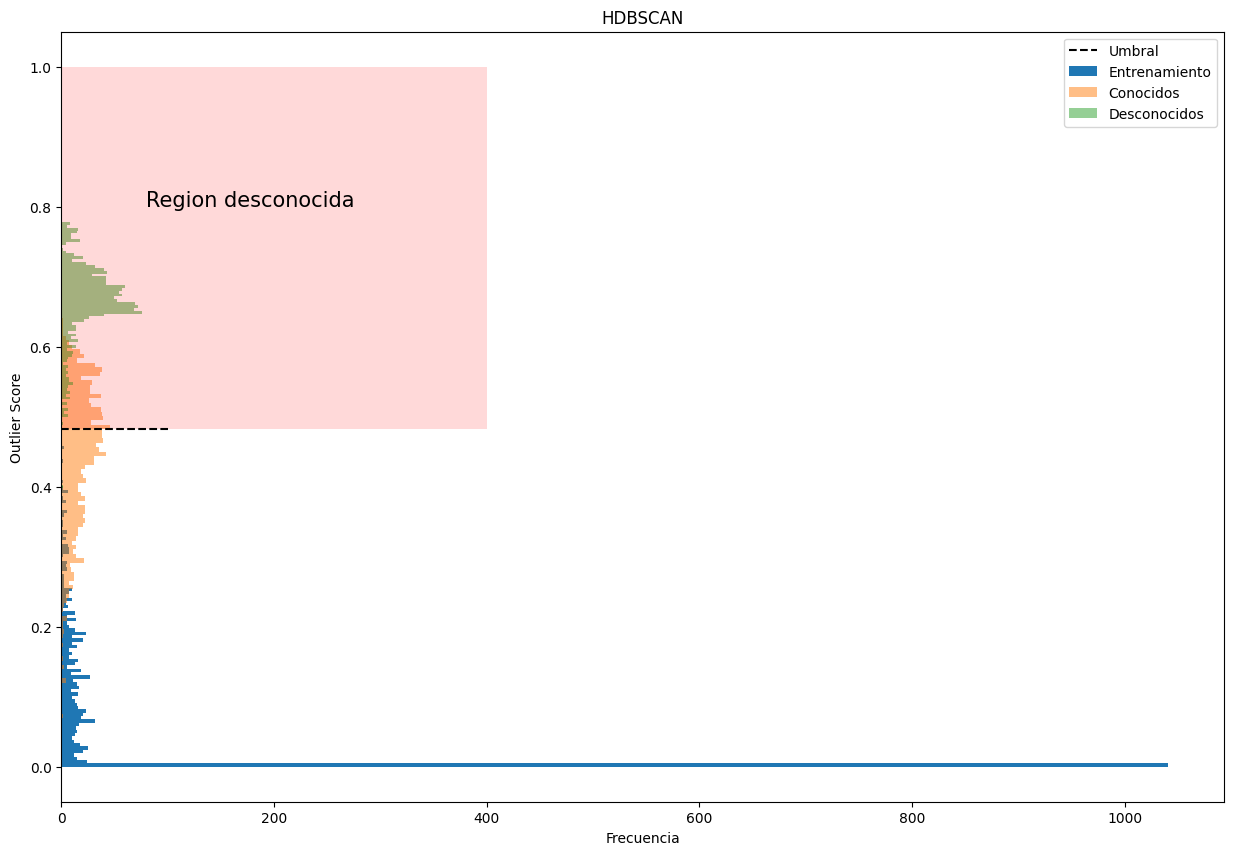

In [9]:
import matplotlib.patches as patches

solution = [10,2,100,0]
data_train = Data_train
data_con = Data_val_con
data_descon = Data_val_descon
percentile = 100
title = 'HDBSCAN'
HD = hdbscan.HDBSCAN(min_cluster_size = int(solution[0]),min_samples = int(solution[1]),prediction_data=True)
HD.fit(data_train)
originals = HD.outlier_scores_
threshold = np.percentile(HD.outlier_scores_, percentile)
outliers = np.where(HD.outlier_scores_ > threshold)[0]
inliers = np.where(HD.outlier_scores_ <= threshold)[0]

shaped_con = np.array(data_con).reshape(Conocidos*img_test,1024)
shaped_descon = np.array(data_descon).reshape(Desconocidos*img_test,1024)

con_scores = hdbscan.approximate_predict_scores(HD,shaped_con)
descon_scores = hdbscan.approximate_predict_scores(HD,shaped_descon)

plt.figure(figsize=(15,10))
plt.hist (originals, bins = 100,orientation='horizontal')
plt.hist(con_scores, bins = 100,alpha = 0.5,orientation='horizontal')
plt.hist(descon_scores, bins = 100,alpha = 0.5,orientation='horizontal')
plt.plot([0, 100],[threshold, threshold], '--', color='k')

# add a key that englobes the outliers



plt.legend(['Umbral','Entrenamiento','Conocidos','Desconocidos'])
rect = patches.Rectangle((0,threshold),400,1-threshold,linewidth=1,edgecolor='None',facecolor='red',alpha = 0.15)
plt.gca().add_patch(rect)
# Move the text to the right of the key 
plt.text(80, 0.8, 'Region desconocida', fontsize=15)


plt.title(title)
plt.ylabel('Outlier Score')
plt.xlabel('Frecuencia')
plt.show()